### Comparing FloodNet sensor data to 311 and FloodWatch data in the same area during times of flooding

In [150]:
import pandas as pd
import pytz
import urllib3
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np
urllib3.disable_warnings()
import pandas as pd
import urllib3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from datetime import datetime as dt
from datetime import date
import datetime
from IPython.core.display import display, HTML
import matplotlib as mpl
from collections import OrderedDict
import numpy as np
from influxdb import InfluxDBClient as InfluxDBClient_old_version
from csv import DictReader
import os
import collections
import random
import json
import math
import requests
import io

import matplotlib
matplotlib.rcParams['timezone'] = 'US/Eastern'

pd.options.mode.chained_assignment = None  # default='warn'
display(HTML('<style>.container { width:100% !important; }</style>'))
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = [24, 12]
plt.style.use('seaborn-whitegrid')
sns.set(font_scale=1.7)
sns.set_context("poster")
sns.set_style("whitegrid")
urllib3.disable_warnings()

import rx
from rx import operators as ops

from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write.retry import WritesRetry
from influxdb_client.client.write_api import SYNCHRONOUS
import geocoder
import glob
from influxdb_client.domain.write_precision import WritePrecision

/var/folders/rt/sj2jtnt93837kjspvxhfn1nr0000gn/T/ipykernel_16314/3917077949.py:18: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [151]:
def pull_flood_data(_url='https://influxdb.floodnet.nyc',
                                    _token='rvEpEpb9bDwrb1NbmlbnmT4HT_XCQxeKn3DHghJu9uABrm1qbHhR9D8eXsoMux9v073wttFRY6FLs6FxM7TuSw==',
                                    _org='floodnet',
                                    dep_id=None,
                                    save_to_location=None,
                                    start_date=None,
                                    stop_date=None,):
    # TBD feature: query from start to stop date ranges passed as function arguments
    result = []
    
    start_date = pd.to_datetime(start_date, format='%Y-%m-%dT%H:%M:%S%z')
    stop_date = pd.to_datetime(stop_date, format='%Y-%m-%dT%H:%M:%S%z')
        
    p = {"_deployment_id": dep_id,
         "_start_date" : start_date, 
         "_stop_date" : stop_date,
        }

    with InfluxDBClient(url=_url, token=_token, org=_org, timeout=1000000) as client:
        query_api = client.query_api()
        query_string = '''from(bucket: "floodnet-live")
                                    |> range(start: _start_date, stop: _stop_date)
                                    |> filter(fn: (r) => r["_measurement"] == "flood-sensor")
                                    |> filter(fn: (r) => r["deployment_id"] == _deployment_id)
                                    |> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
                                '''
        result = query_api.query_data_frame(query_string, params=p)
        if type(result) == list:
            result = pd.concat(result)

    result.drop(columns=['_start', '_stop', 'result', 'table'], inplace=True)
    result.rename(columns={'_time': 'time', '_measurement': 'measurement'}, inplace=True)
    result['time'] = pd.to_datetime(result['time'], format="%Y-%m-%d %H:%M:%S.%f", utc=True)
    result.set_index('time', inplace=True)
    result = result.sort_values(by=['time'])
    return result

In [152]:
df311 = pd.read_csv('../data/311ServiceRequests.csv')

df311['Created Date'] = pd.to_datetime(df311['Created Date'])

/var/folders/rt/sj2jtnt93837kjspvxhfn1nr0000gn/T/ipykernel_16314/2582542631.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df311 = pd.read_csv('../data/311ServiceRequests.csv')


In [153]:
def plot_sensor_and_complaints(deployment_id, st_dateFN, en_dateFN, st_date311, en_date311, latitude, longitude, dfFW):
    df1 = df311[df311['Created Date'].dt.date >= st_date311] 
    df1 = df1[df1['Created Date'].dt.date <= en_date311]

    fig, ax_array = plt.subplots(figsize=(30,10))

    df = pull_flood_data(dep_id=deployment_id, start_date=st_dateFN, stop_date=en_dateFN)
    df['depth-inch'] = df['depth_proc_mm'] / 25.4
    df_int = df['depth-inch'].resample('1s').mean().interpolate(method='cubic', order=1)

    ax_array.plot(df_int, label = deployment_id)

    date_form = mdates.DateFormatter("%m/%d %H:%M")
    ax_array.xaxis.set_major_formatter(date_form)

    ax2 = ax_array.twinx()

    counts_by_day311 = {}
    df1['date'] = df1['Created Date'].dt.date
    for index, row in df1.iterrows():
        if latitude[0] < row['Latitude'] < latitude[1] and longitude[0] < row['Longitude'] < longitude[1]:
            if row['Created Date'] not in counts_by_day311:
                counts_by_day311[row['Created Date']] = 1
            else:
                counts_by_day311[row['Created Date']] += 1

    print(counts_by_day311)

    x = list(counts_by_day311.keys())
    y = list(counts_by_day311.values())

    ax2.scatter(x,y, color='red', s=100, label = '311 Complaints')

    ax2.set_yticks([])

    ax_array.set_ylabel('Flood Depth (inches)')
    ax_array.set_title('Floods vs 311 Flood Complaints')

    ax3 = ax_array.twinx()
    ax3.set_yticks([])

    dfFW = dfFW[dfFW['Date'].dt.date >= st_date311]
    dfFW = dfFW[dfFW['Date'].dt.date <= en_date311]

    x = np.array(dfFW['Date'])
    y = np.array(dfFW['Count'])

    ax3.scatter(x, y, color='green', s=100, label = 'FloodWatch Reports')

    axes = [ax_array, ax2, ax3]

    lines = []
    labels = []

    for ax in axes:
        Line, Label = ax.get_legend_handles_labels()
        lines.extend(Line)
        labels.extend(Label)

    ax_array.legend(lines, labels, loc='upper right', framealpha = .2, frameon=True)


In [154]:
#latitude +- 0.005, longitude +- .012

{Timestamp('2022-01-01 23:18:00'): 1, Timestamp('2022-01-02 07:34:00'): 1}


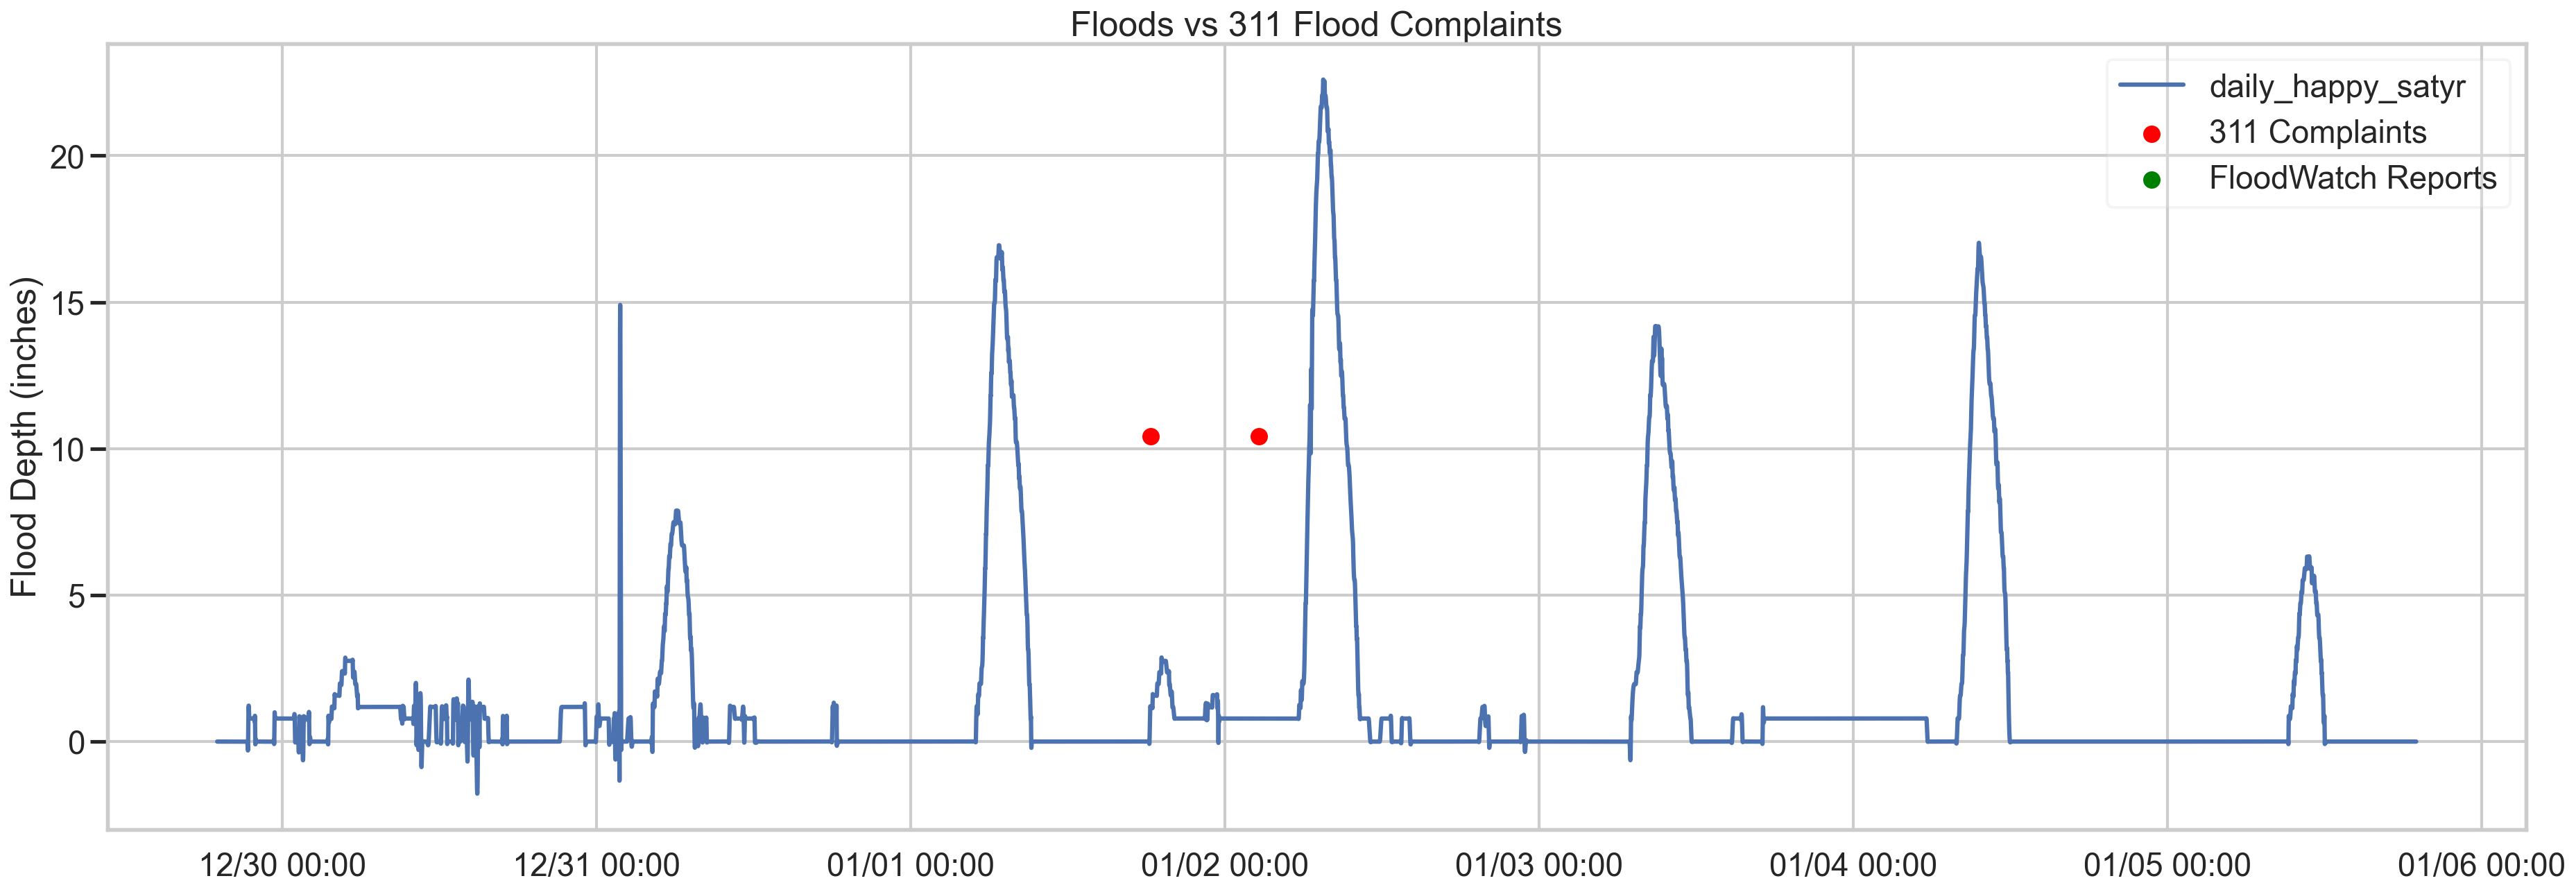

In [155]:
df84 = pd.read_csv('../data/Beach84thFloodWatch.csv')
df84.rename(columns={'please_enter_todays_date': 'Date', 'Count_objectid': 'Count'}, inplace=True)

df84['Date'] = pd.to_datetime(df84['Date'])

plot_sensor_and_complaints('daily_happy_satyr', '2021-12-30T00:00:00', '2022-01-06T00:00:00', date(2021, 12, 30), date(2022, 1, 6), (40.58399808, 40.59399808), (-73.82199834, -73.79799834), df84)

{}


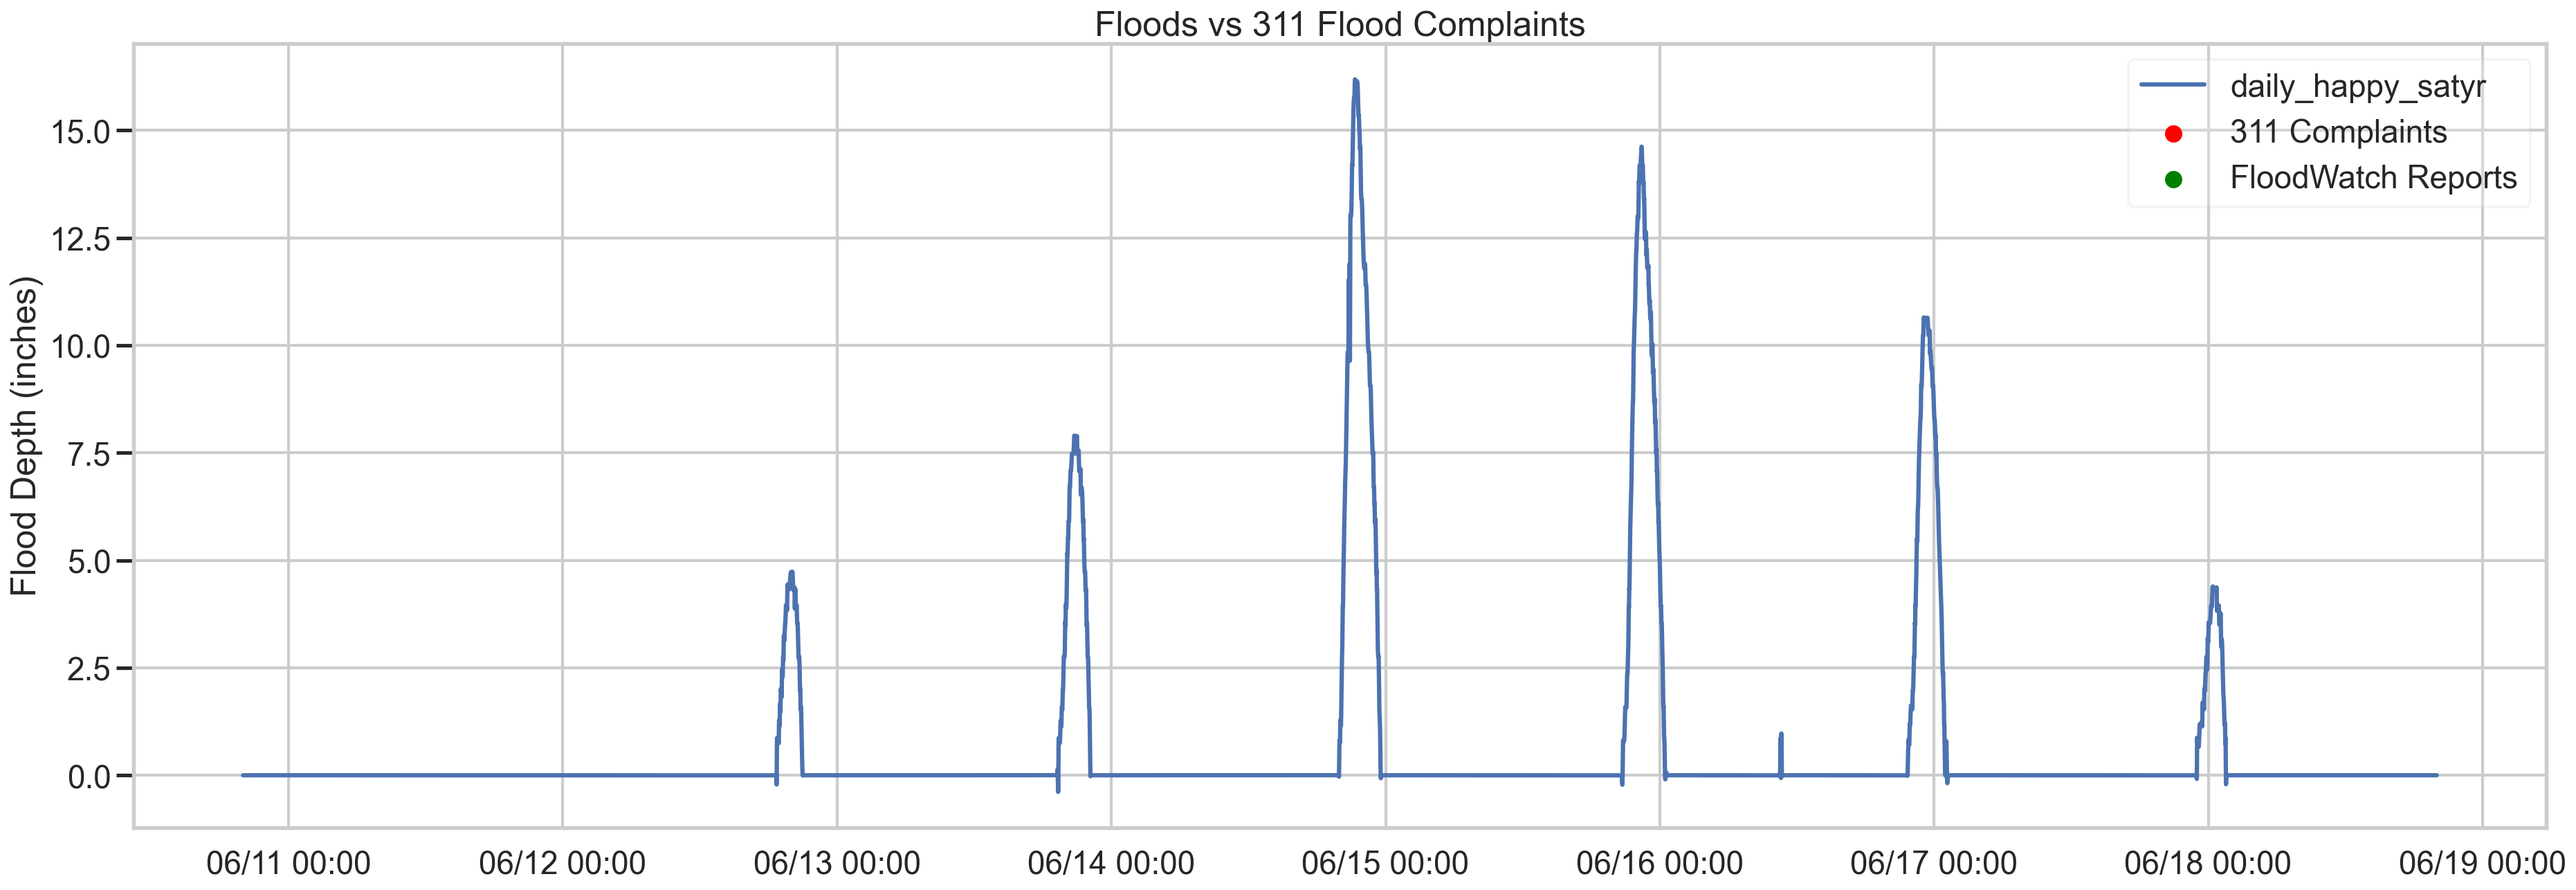

In [156]:
plot_sensor_and_complaints('daily_happy_satyr', '2022-06-11T00:00:00', '2022-06-19T00:00:00', date(2022, 6, 11), date(2022, 6, 19), (40.58399808, 40.59399808), (-73.82199834, -73.79799834), df84)

{}


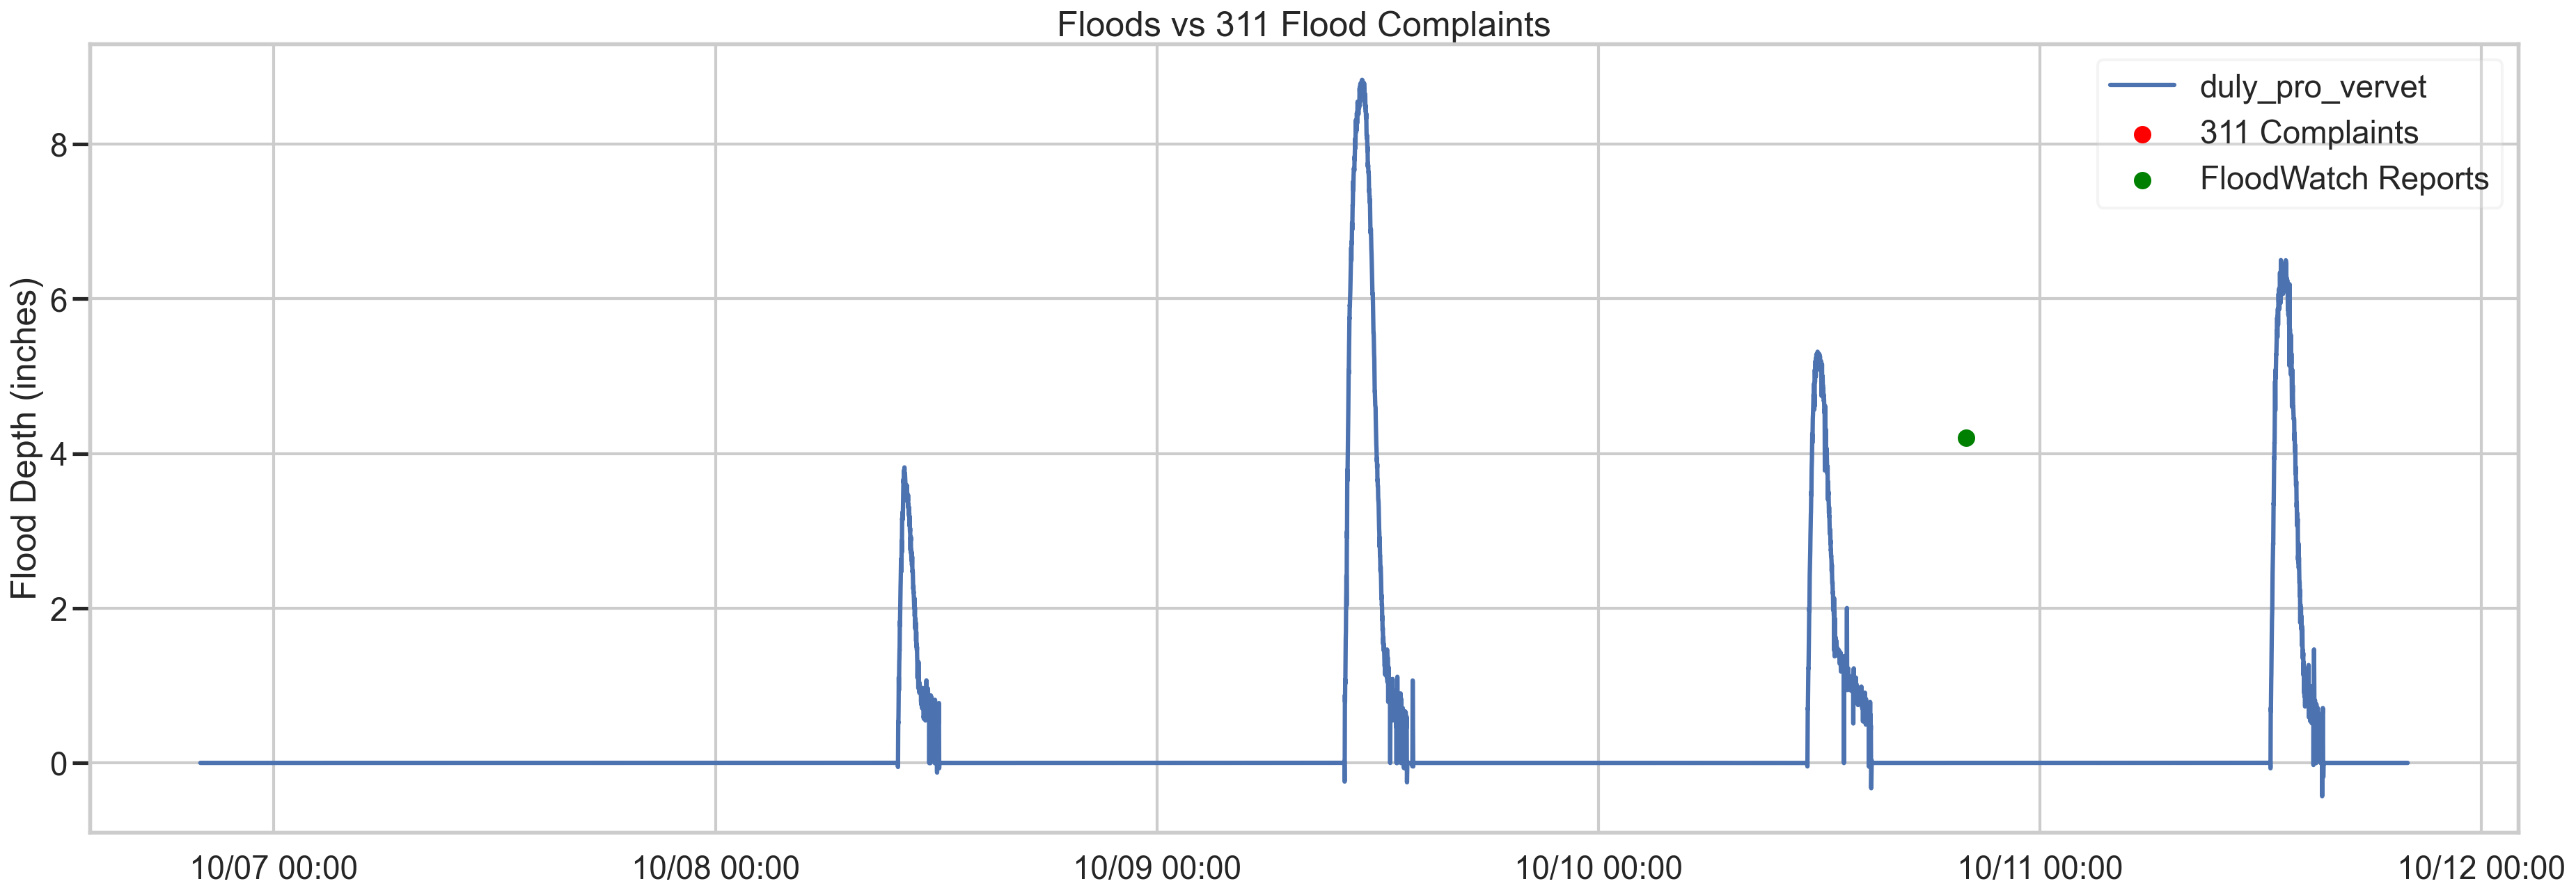

In [157]:
dfRussell = pd.read_csv('../data/RussellStFloodWatch.csv')
dfRussell.rename(columns={'please_enter_todays_date': 'Date', 'Count_objectid': 'Count'}, inplace=True)

dfRussell['Date'] = pd.to_datetime(dfRussell['Date'])

plot_sensor_and_complaints('duly_pro_vervet', '2021-10-07T00:00:00', '2021-10-12T00:00:00', date(2021, 10, 7), date(2021, 10, 11), (40.6492974, 40.6592974), (-73.8436683, -73.8196683), dfRussell)
#try wider range on this

{Timestamp('2021-10-07 13:52:00'): 1, Timestamp('2021-10-07 10:25:00'): 1}


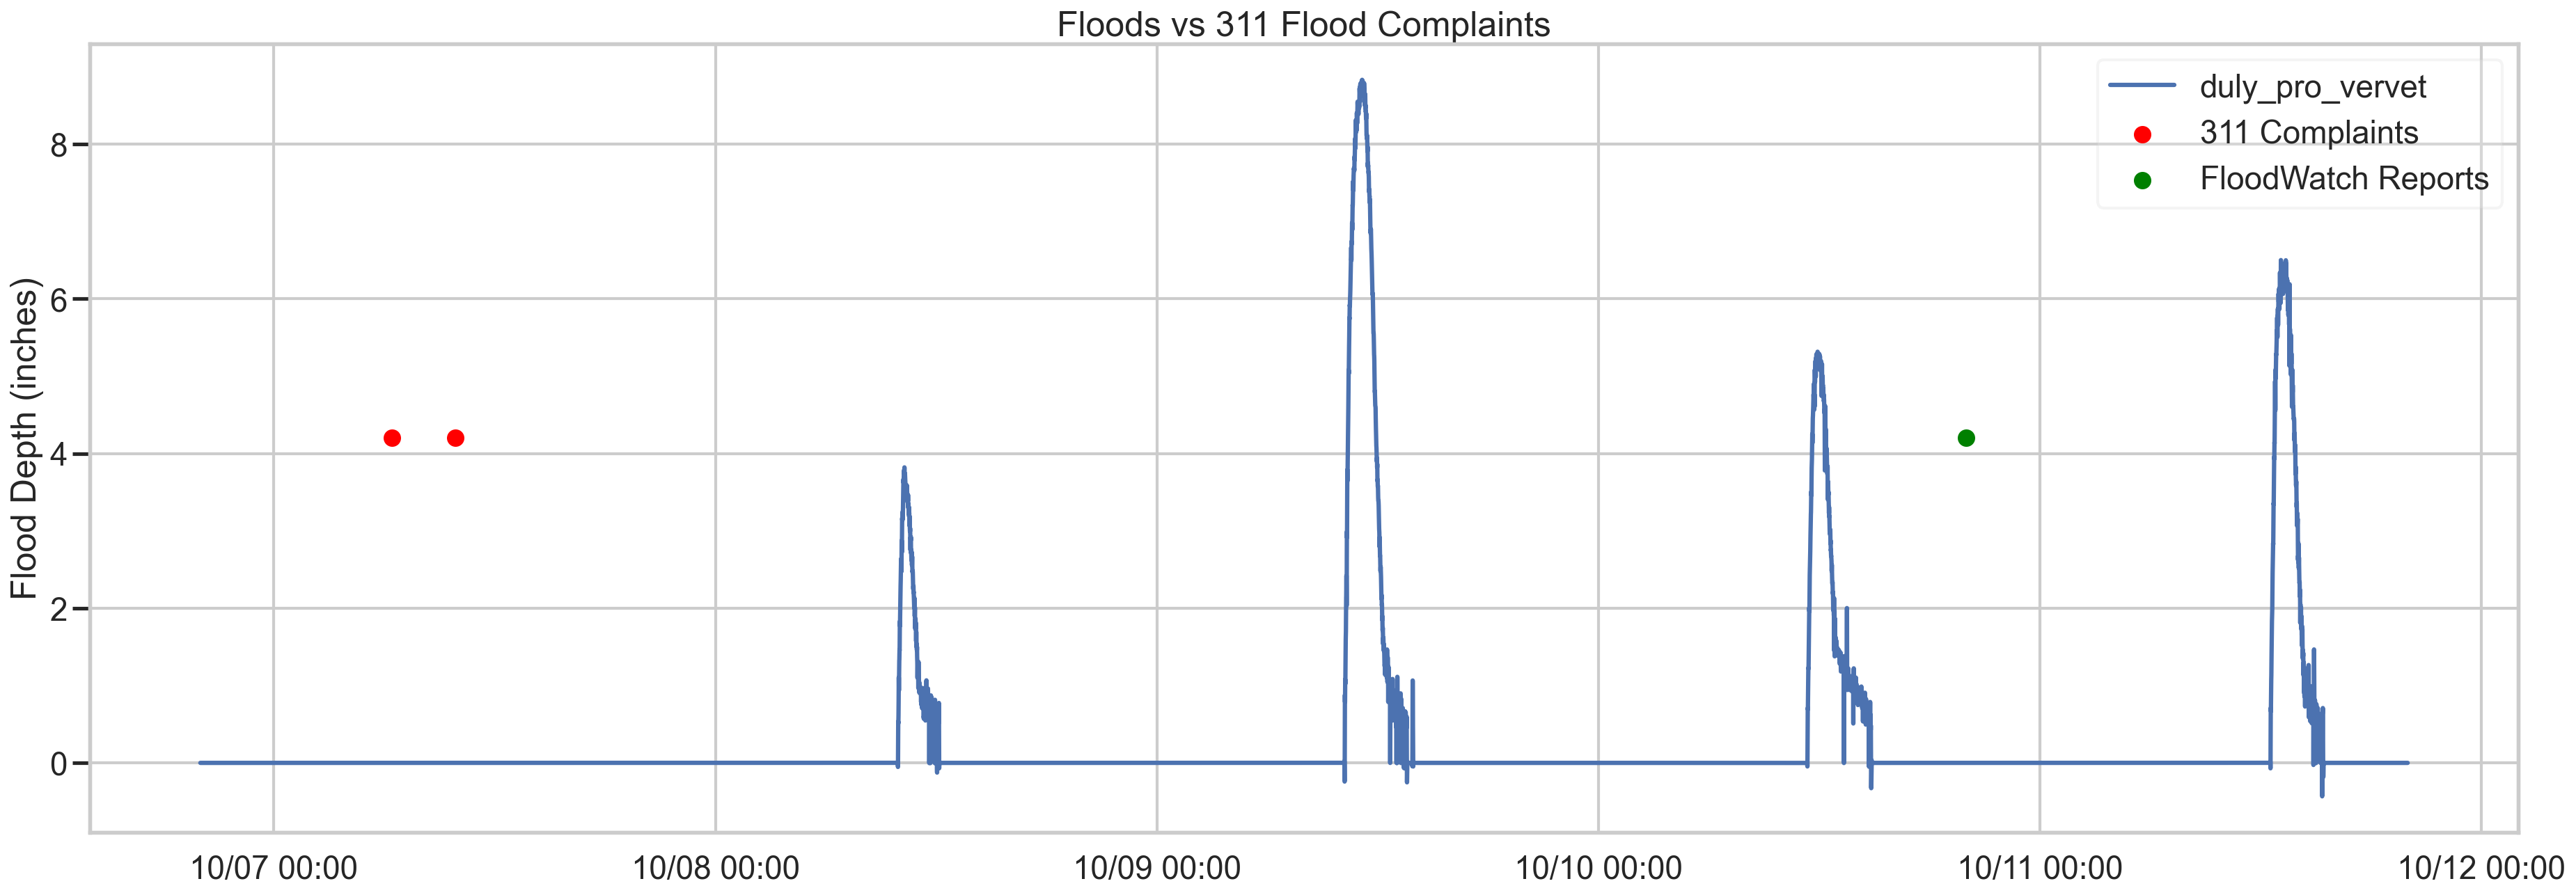

In [158]:
plot_sensor_and_complaints('duly_pro_vervet', '2021-10-07T00:00:00', '2021-10-12T00:00:00', date(2021, 10, 7), date(2021, 10, 11), (40.6, 40.7), (-73.9, -73.7), dfRussell)

{}


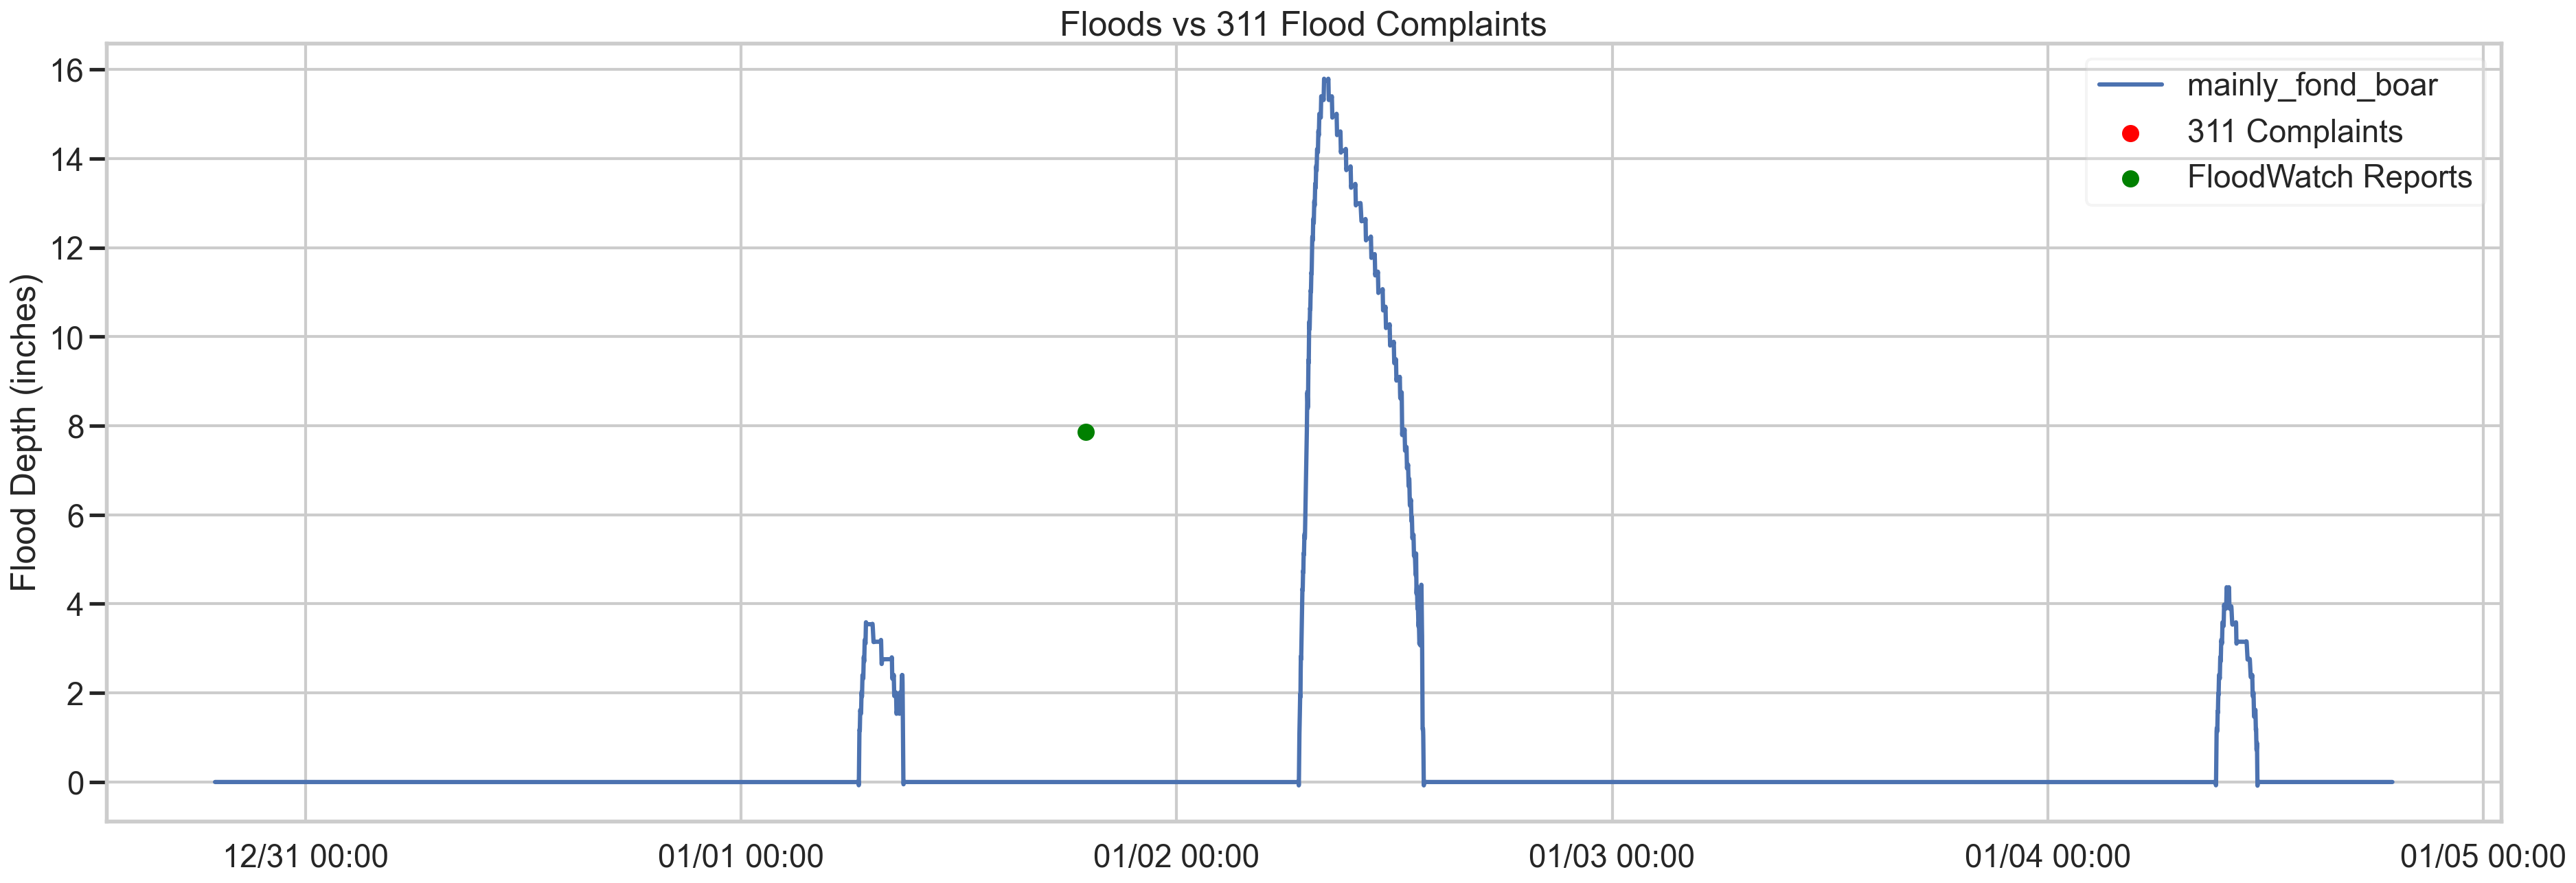

In [159]:
dfDavenport = pd.read_csv('../data/DavenportCtFloodWatch.csv')
dfDavenport.rename(columns={'please_enter_todays_date': 'Date', 'Count_objectid': 'Count'}, inplace=True)

dfDavenport['Date'] = pd.to_datetime(dfDavenport['Date'])


plot_sensor_and_complaints('mainly_fond_boar', '2021-12-31T00:00:00', '2022-01-05T00:00:00', date(2021, 12, 31), date(2022, 1, 5), (40.6483868, 40.6583868), (-73.8425586, -73.8185586), dfDavenport)

{Timestamp('2022-01-03 13:26:00'): 1, Timestamp('2022-01-02 15:34:00'): 1, Timestamp('2022-01-02 16:43:00'): 1}


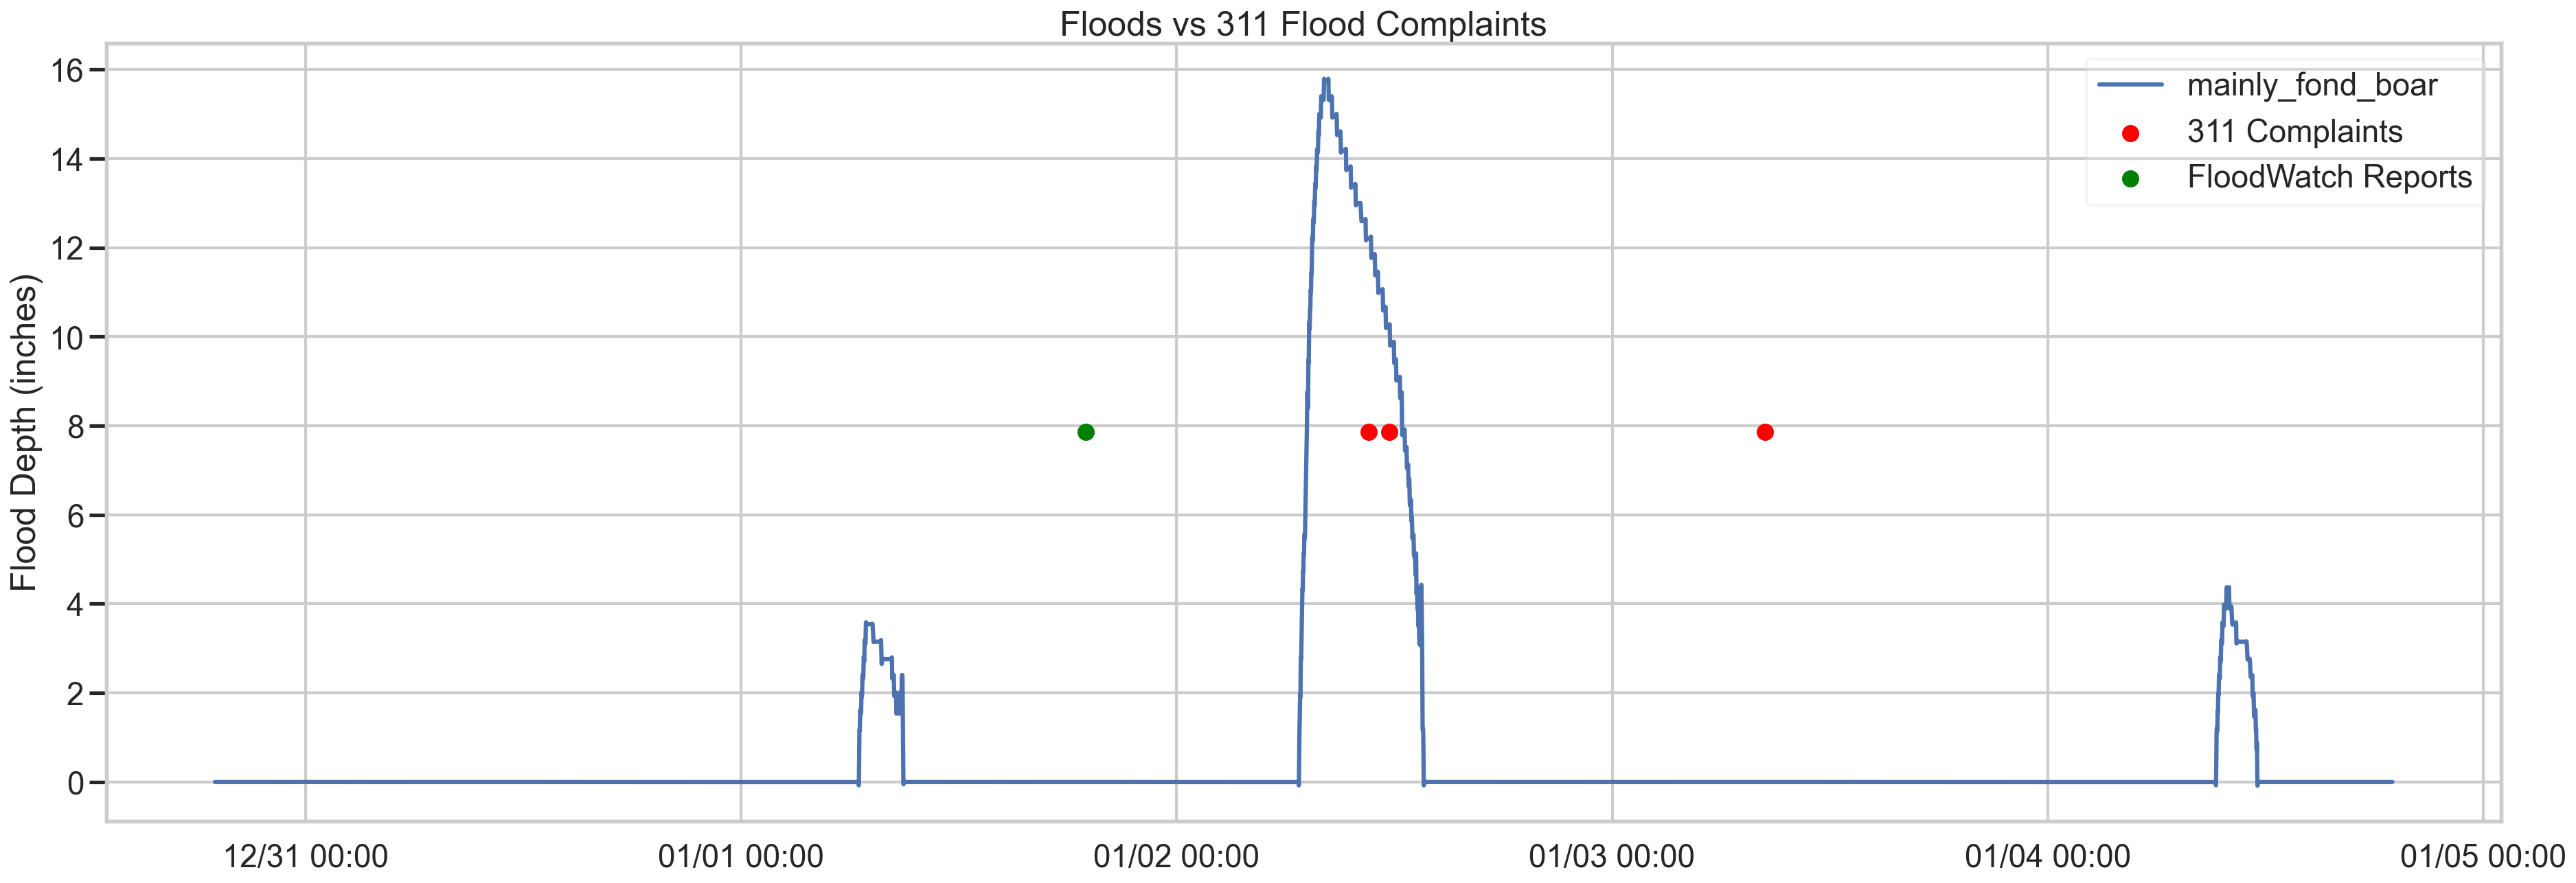

In [160]:
plot_sensor_and_complaints('mainly_fond_boar', '2021-12-31T00:00:00', '2022-01-05T00:00:00', date(2021, 12, 31), date(2022, 1, 5), (40.62, 40.67), (-73.87, -73.79), dfDavenport)

{Timestamp('2021-02-16 09:35:00'): 1, Timestamp('2021-02-22 14:40:00'): 1, Timestamp('2021-02-25 17:28:00'): 1, Timestamp('2021-02-28 18:44:00'): 1, Timestamp('2021-03-25 08:09:00'): 1, Timestamp('2021-03-28 11:02:00'): 1, Timestamp('2021-03-25 09:26:00'): 1, Timestamp('2021-03-28 23:13:00'): 1}


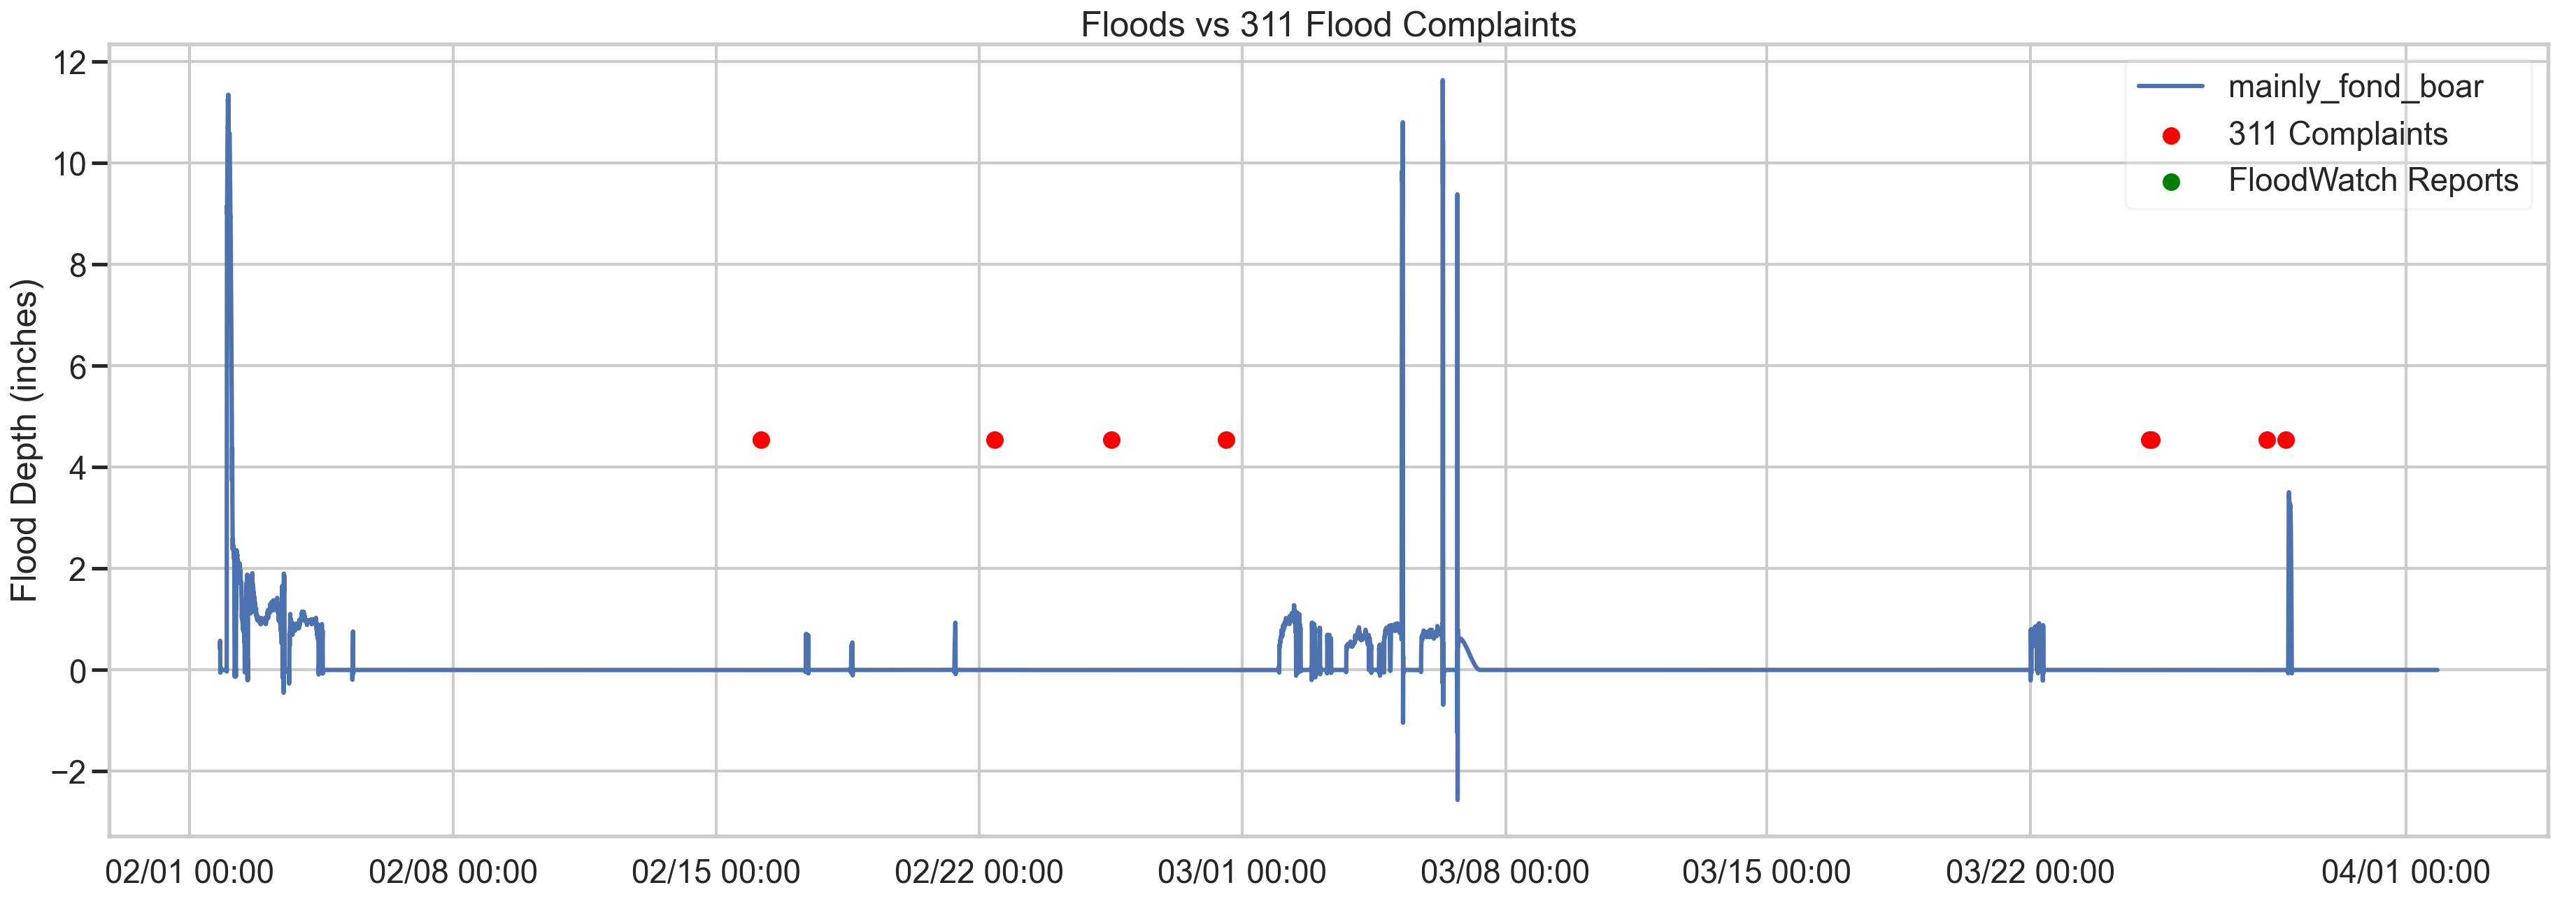

In [161]:
plot_sensor_and_complaints('mainly_fond_boar', '2021-02-02T00:00:00', '2021-04-02T00:00:00', date(2021, 2, 2), date(2021, 4, 2), (40.62, 40.67), (-73.87, -73.79), dfDavenport)

{Timestamp('2021-06-01 13:23:00'): 1, Timestamp('2021-05-04 09:04:00'): 1, Timestamp('2021-05-29 10:19:00'): 1, Timestamp('2021-05-31 12:10:00'): 1, Timestamp('2021-06-01 14:10:00'): 1, Timestamp('2021-05-29 14:57:00'): 1, Timestamp('2021-06-01 08:19:00'): 1}


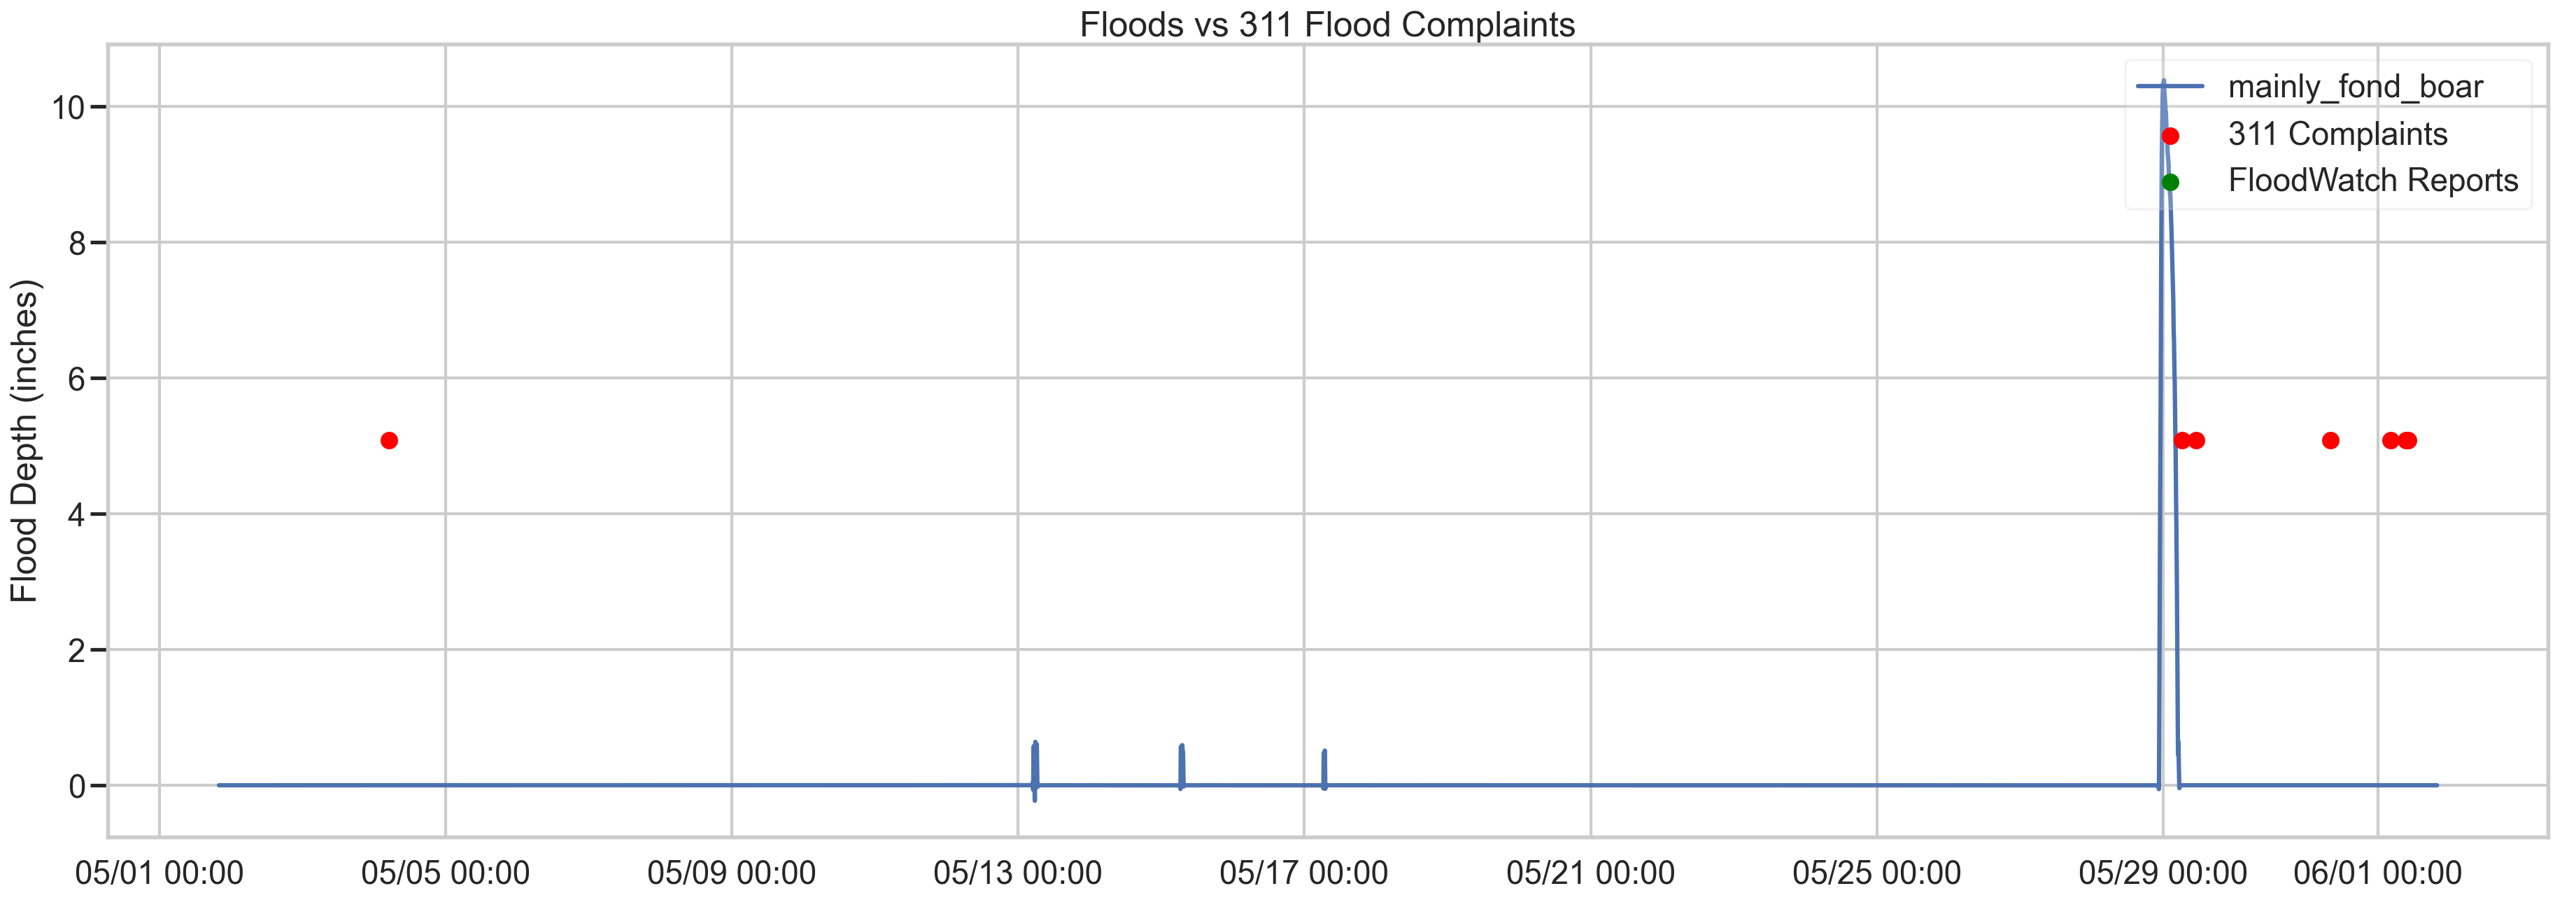

In [162]:
plot_sensor_and_complaints('mainly_fond_boar', '2021-05-02T00:00:00', '2021-06-02T00:00:00', date(2021, 5, 2), date(2021, 6, 2), (40.62, 40.67), (-73.87, -73.79), dfDavenport)

{Timestamp('2022-01-03 13:26:00'): 1, Timestamp('2022-01-02 15:34:00'): 1, Timestamp('2022-01-02 16:43:00'): 1}


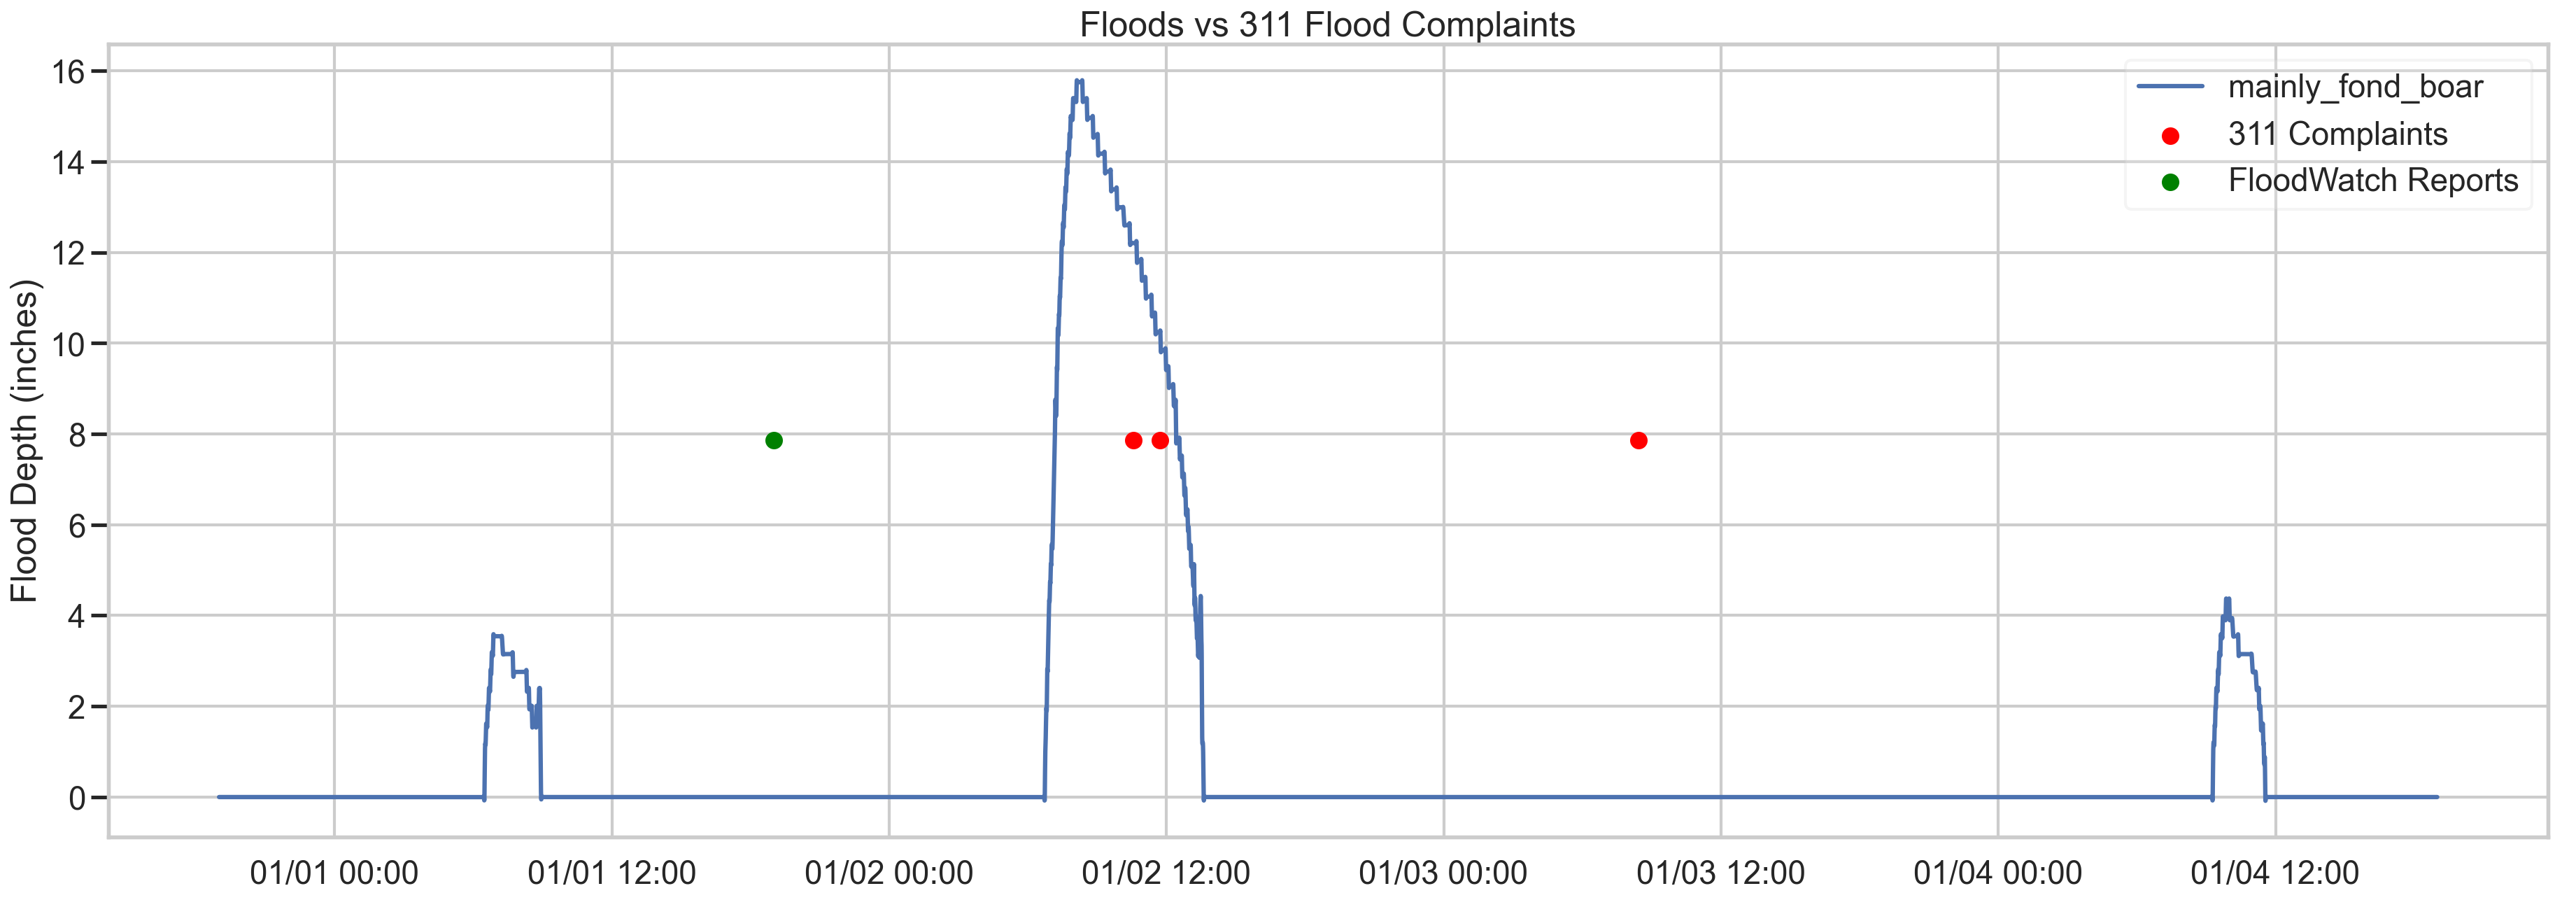

In [164]:
plot_sensor_and_complaints('mainly_fond_boar', '2022-01-01T00:00:00', '2022-01-05T00:00:00', date(2022, 1, 1), date(2022, 1, 5), (40.62, 40.67), (-73.87, -73.79), dfDavenport)

{Timestamp('2022-04-12 08:45:00'): 1, Timestamp('2022-04-19 07:52:00'): 1, Timestamp('2022-04-19 12:23:00'): 1, Timestamp('2022-04-08 08:51:00'): 1, Timestamp('2022-04-10 09:35:00'): 1, Timestamp('2022-04-06 13:47:00'): 1}


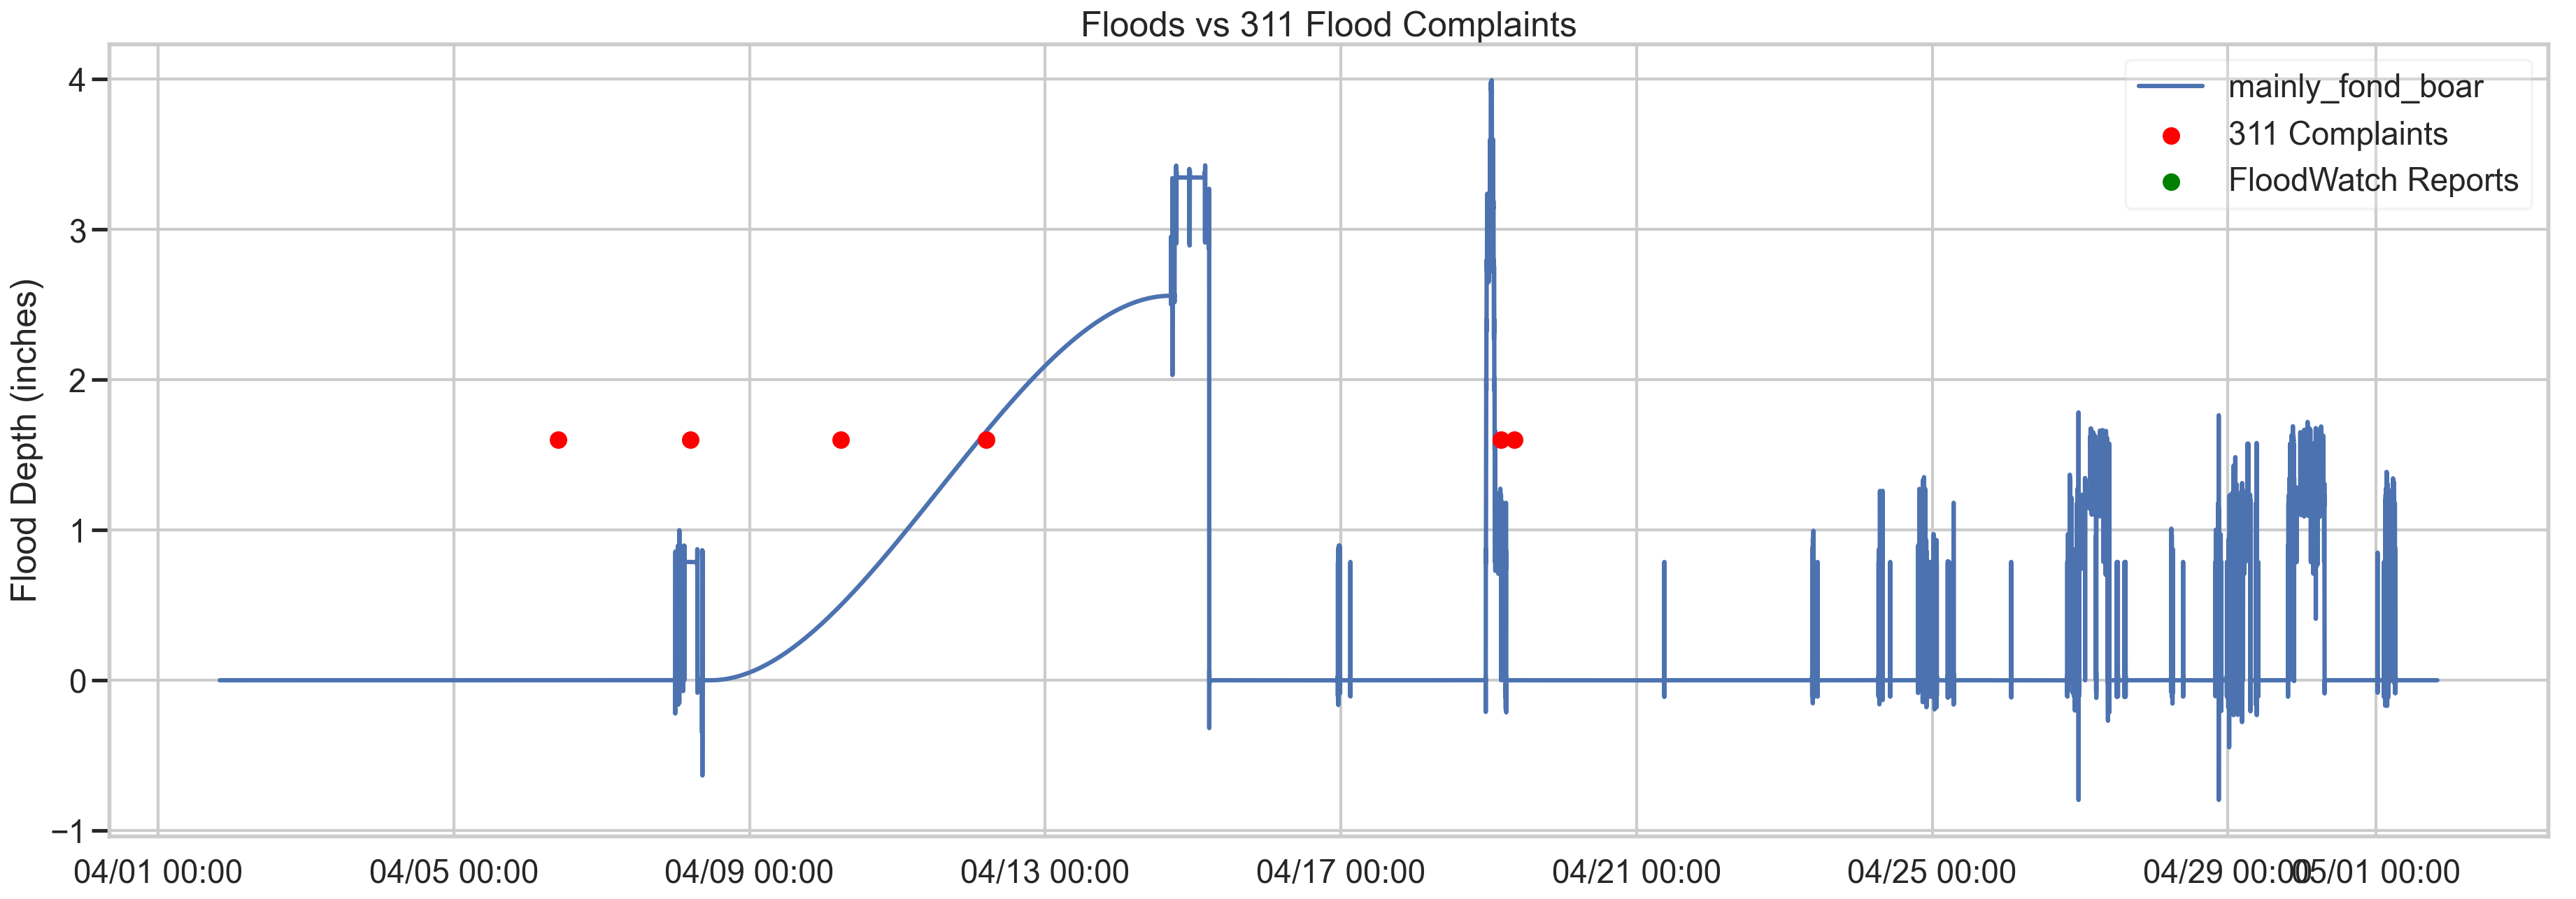

In [165]:
plot_sensor_and_complaints('mainly_fond_boar', '2022-04-02T00:00:00', '2022-05-02T00:00:00', date(2022, 4, 2), date(2022, 5, 2), (40.62, 40.67), (-73.87, -73.79), dfDavenport)